In [1]:
# !pip install netCDF4
# !pip install cartopy
# !pip install basemap 


In [2]:
import netCDF4 as nc
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import interpolate

In [3]:
import tqdm

In [4]:
# Constructing a relative path to move one directory backward
data_relative_path = os.path.join('..', 'Data','CMIP6')
precipitation_path = os.path.join(data_relative_path,'Precipitation')
WTIO_path = os.path.join(data_relative_path,'WTIO')
SEIO_path = os.path.join(data_relative_path,'SEIO')

In [5]:
file_path = "pr_Amon_CAMS-CSM1-0_historical_r1i1p1f1_gn_19811016-20101016_v20190708.nc"
data = nc.Dataset(f"{precipitation_path}/{file_path}")


# Initial data Analysis and Presentation

First, we select the latitude and longitude range for the Middle East (25°N to 40°N, 25°E to 40°E)

# Todo
     know the differences between the interpulation bicubic bilinear etc..

In [6]:
def collect_all_datasets(precipitation_dir: str) -> np.ndarray:
    """
    Collects and processes all NetCDF files from the given directory.
    Interpolates each dataset to a 16x16 matrix and stores them in a 3D array.
    
    Args:
        precipitation_path (str): Path to the directory containing NetCDF files.
    
    Returns:
        np.ndarray: 3D array of interpolated datasets.
    """
    interpolated_matrices = []

    # Iterate through all files in the directory
    for file in tqdm.tqdm(os.listdir(precipitation_dir)):
        filename = os.fsdecode(file)
        path = f"{precipitation_dir}/{filename}"
        data = nc.Dataset(path)
        
        # Determine the latitude and longitude variable names
        lat_name = 'lat' if 'lat' in data.variables else 'latitude'
        lon_name = 'lon' if 'lon' in data.variables else 'longitude'
        
        lat = data.variables[lat_name][:]
        lon = data.variables[lon_name][:]
        
        # Subset the lat and lon for the Middle East region
        lat = lat[(lat >= 25) & (lat <= 40)]
        lon = lon[(lon >= 25) & (lon <= 40)]
        
        precipitation = data.variables['pr'][:]
        avg_pr_middle_east = np.mean(precipitation, axis=0)
        
        convert_unit_to_mm_transform = 86400 * 31
        mm_avg_lat_lon = avg_pr_middle_east * convert_unit_to_mm_transform
        
        original_matrix = mm_avg_lat_lon
        m, n = original_matrix.shape
        
        target_dim = (16, 16)
        
        # Generate the interpolation function
        f = interpolate.interp2d(np.linspace(0, 1, n), 
                                 np.linspace(0, 1, m), 
                                 original_matrix, kind='cubic')
        
        # Generate the interpolated matrix
        interpolated_matrix = f(np.linspace(0, 1, 16), np.linspace(0, 1, 16))
        
        # Append the interpolated matrix to the list
        interpolated_matrices.append(interpolated_matrix)

    # Convert the list of interpolated matrices to a 3D NumPy array
    return np.array(interpolated_matrices)

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 52.15it/s]


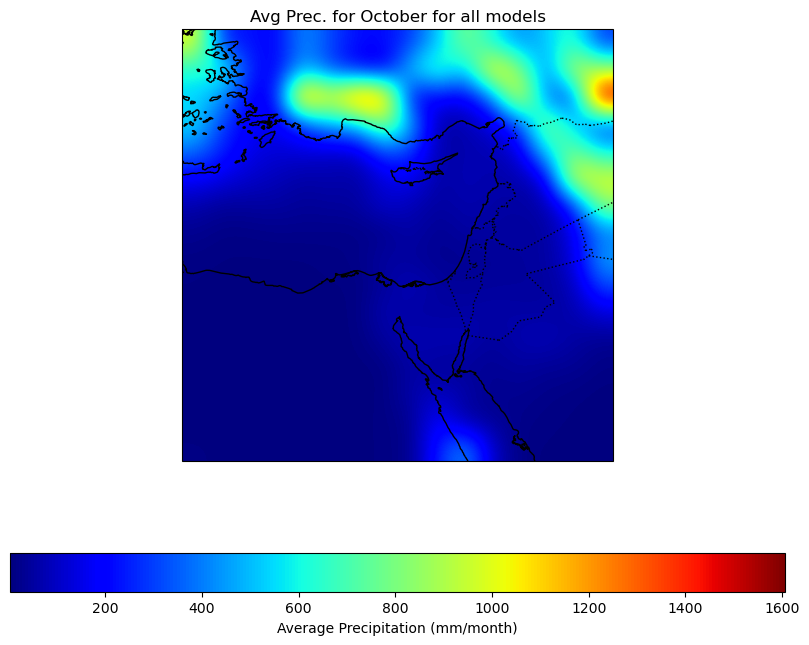

In [14]:
# collect all dataset(model) in the parcipitation dir and make a np array in shape (datasets number,lat_grid,long_grid)
interpulated_matrix_array = collect_all_datasets(precipitation_path)
interpulated_matrix_array_mean = np.mean(interpulated_matrix_array,axis=0)
interpulated_matrix_array_varience = np.var(interpulated_matrix_array,axis=0)


# baundries of the map in lat,long units
baundries = [25, 40,25,40]

#     Plot the map with the heatmap overlay
plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(baundries, crs=ccrs.PlateCarree())


# Add map features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, color='lightgray')


plt.imshow(interpulated_matrix_array_varience, origin='lower', cmap='jet', extent=baundries,
           transform=ccrs.PlateCarree(), interpolation='bicubic')

# Add colorbar
cbar = plt.colorbar(label='Average Precipitation (mm/month)', orientation='horizontal')
cbar.set_label('Average Precipitation (mm/month)')
plt.title(f'Avg Prec. for October for all models')
plt.show()

# maybe the rest is redundent now, i didn't know what to do with the headlines so i left it to you 

In [8]:
lat = data.variables['lat'][(25 <= data.variables['lat'][:] ) & (data.variables['lat'][:] <= 40)]
lon = data.variables['lon'][(25 <= data.variables['lon'][:]) & (data.variables['lon'][:] <= 40)]

Next, we extract the precipitation data for the Middle East region and average it over the 30-year period.

In [9]:
precipitation = data.variables['pr'][:]
avg_pr_middle_east = np.mean(precipitation,axis=0)

An important step - we need to convert the precipitation units from kg m-2 s-1 to mm/month. To do so, we multiply the precipitation values by the number of seconds in a day (86400) and the number of days in a month (31). Along the way we multiply and divide by 1000 to convert the units from kg to g and then to mm.

In [10]:
convert_unit_to_mm_transform = (86400*31) 
mm_avg_lat_lon = avg_pr_middle_east * convert_unit_to_mm_transform 

Finally, we plot the average precipitation for the Middle East region for the month of October.

NameError: name 'interpolated_matrix' is not defined

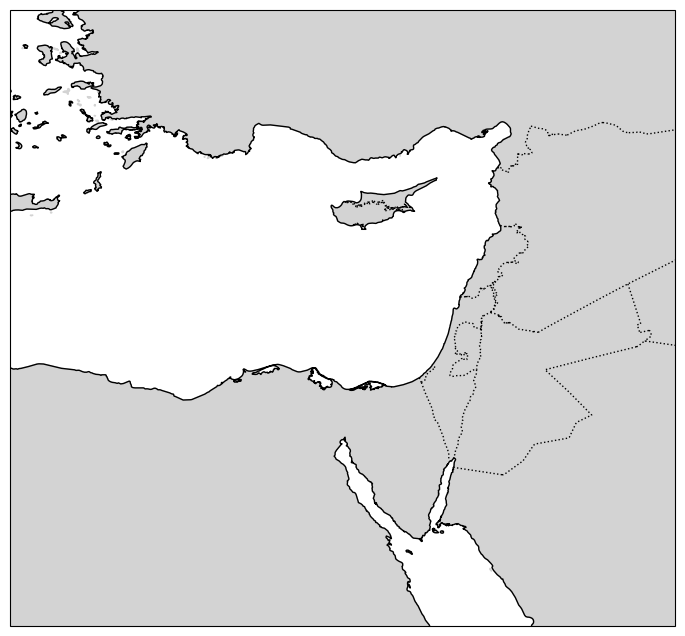

In [11]:
# Plot the map with the heatmap overlay
plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([min(lat), max(lat),min(lon),max(lon)], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, color='lightgray')

plt.imshow(interpolated_matrix, origin='lower', cmap='jet', extent=[lon[0], lon[-1], lat[0], lat[-1]],
           transform=ccrs.PlateCarree(), interpolation='nearest')

# Add colorbar
cbar = plt.colorbar(label='Average Precipitation (mm/month)', orientation='horizontal')
cbar.set_label('Average Precipitation (mm/month)')
plt.title('Average Precipitation for October in the Middle East')

plt.show()